# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO<sub>2</sub>, CO, O<sub>3</sub> and SO<sub>2</sub>.

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression

In [24]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'
sensor = 'tropomi'
component_nom = 'NO2'
    
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [5]:
# Define latitudes and longitudes
lat_min = 48.5
lat_max = 51.1
lon_min = 12
lon_max = 18.9

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
print('SEARCH PERIOD')

# TROPOMI
dates = ('2021-08-21T00:00:00Z', '2021-08-21T23:00:00Z',
        '2021-08-22T00:00:00Z', '2021-08-22T23:00:00Z')
period = pairwise(dates)
start_date = dates[0].split('T')[0]
end_date = dates[-1].split('T')[0]
print(f'- In hours: {period}')

SEARCH PERIOD
- In hours: [('2021-08-21T00:00:00Z', '2021-08-21T23:00:00Z'), ('2021-08-22T00:00:00Z', '2021-08-22T23:00:00Z')]


## 2. Sensor data

### Collect and read data as xarray

In [6]:
sensor_product_names = []

for i in range(0, len(period)):
    
    input_type = 'Query'
    processing_mode = 'Near real time' # Offline, Near real time, Reprocessing
    file_name, sensor_product_name, sensor_type = TROPOMI_download(input_type, bbox, period[i], product_type, processing_mode)
    sensor_product_names.append(sensor_product_name)

You can see all the results at https://s5phub.copernicus.eu/dhus/.
RESULTS FOR PERIOD ('2021-08-21T00:00:00Z', '2021-08-21T23:00:00Z')
Number 0: S5P_NRTI_L2__NO2____20210821T115635_20210821T120135_19977_02_020200_20210821T130021
SELECTED
File name: 3c0cad64-2a3b-497d-be7a-deab77ab7ac8
Product name: S5P_NRTI_L2__NO2____20210821T115635_20210821T120135_19977_02_020200_20210821T130021.nc
The file exists, it will not be downloaded again.
You can see all the results at https://s5phub.copernicus.eu/dhus/.
RESULTS FOR PERIOD ('2021-08-22T00:00:00Z', '2021-08-22T23:00:00Z')
Number 0: S5P_NRTI_L2__NO2____20210822T113635_20210822T114135_19991_02_020200_20210822T124046
SELECTED
File name: 47fefdcb-c0b0-4090-afa2-d713dc2357c5
Product name: S5P_NRTI_L2__NO2____20210822T113635_20210822T114135_19991_02_020200_20210822T124046.nc
The file exists, it will not be downloaded again.


In [7]:
sensor_ds, support_input_ds, support_details_ds = TROPOMI_read(sensor_product_names, component_nom)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

In [8]:
support_details_ds

<xarray.Dataset>
Dimensions:                                                (ground_pixel: 450, intensity_offset_polynomial_exponents: 1, polynomial_exponents: 6, scanline: 373, time: 2)
Coordinates:
  * scanline                                               (scanline) float64 ...
  * time                                                   (time) datetime64[ns] ...
  * ground_pixel                                           (ground_pixel) float64 ...
Dimensions without coordinates: intensity_offset_polynomial_exponents, polynomial_exponents
Data variables: (12/45)
    processing_quality_flags                               (time, scanline, ground_pixel) float64 ...
    number_of_spectral_points_in_retrieval                 (time, scanline, ground_pixel) float32 ...
    number_of_iterations                                   (time, scanline, ground_pixel) float64 ...
    wavelength_calibration_offset                          (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_offset_precision                (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_stretch                         (time, scanline, ground_pixel) float32 ...
    ...                                                     ...
    degrees_of_freedom                                     (time, scanline, ground_pixel) float32 ...
    air_mass_factor_stratosphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_cloudy                                 (time, scanline, ground_pixel) float32 ...
    air_mass_factor_clear                                  (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_ghost_column                           (time, scanline, ground_pixel) float32 ...
    cloud_selection_flag                                   (time, scanline, ground_pixel) float32 ...

In [9]:
support_input_ds

<xarray.Dataset>
Dimensions:                                (ground_pixel: 450, scanline: 373, time: 2)
Coordinates:
  * scanline                               (scanline) float64 0.0 1.0 ... 372.0
  * time                                   (time) datetime64[ns] 2021-08-21 2...
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
Data variables: (12/18)
    surface_altitude                       (time, scanline, ground_pixel) float32 ...
    surface_altitude_precision             (time, scanline, ground_pixel) float32 ...
    surface_classification                 (time, scanline, ground_pixel) float32 ...
    instrument_configuration_identifier    (time, scanline) float64 12.0 ... nan
    instrument_configuration_version       (time, scanline) float32 17.0 ... nan
    scaled_small_pixel_variance            (time, scanline, ground_pixel) float32 ...
    ...                                     ...
    cloud_fraction_crb                     (time, scanline, ground_pixel) float32 ...
    cloud_albedo_crb                       (time, scanline, ground_pixel) float32 ...
    scene_albedo                           (time, scanline, ground_pixel) float32 ...
    apparent_scene_pressure                (time, scanline, ground_pixel) float32 ...
    snow_ice_flag                          (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388                  (time, scanline, ground_pixel) float32 ...

### Calculate level pressures

In [10]:
sensor_ds = TROPOMI_pressure(sensor_ds, component_nom, support_input_ds, support_details_ds)
sensor_ds

The layers pressures will be calculated (lower and upper bounds).


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/13)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...

### Calculate column kernels

In [11]:
sensor_ds = TROPOMI_column_kernel(sensor_ds, support_details_ds)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...
    column_kernel                                         (layer, time, scanline, ground_pixel) float32 ...

### Retrieve apriori profiles

In [12]:
sensor_ds = TROPOMI_apriori_profile(sensor_ds, component, support_details_ds)
sensor_ds

The dataset does not contain any apriori profile.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...
    column_kernel                                         (layer, time, scanline, ground_pixel) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [13]:
sensor_ds = sensor_convert_units(sensor_ds, sensor_column, sensor)
sensor_ds

The sensor component units are mol m**-2. They will be converted to molecules cm**-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...
    column_kernel                                         (layer, time, scanline, ground_pixel) float32 ...

## 3. Model data

### Download, read and subset data as xarray

In [14]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, model_full_name, model_level = 'Multiple')
model_ds = CAMS_read(model_product_name, component, component_nom)
model_ds = subset(model_ds, bbox)
model_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 18, step: 4, time: 2)
Coordinates:
  * time        (time) datetime64[ns] 2021-08-21 2021-08-22
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-05T08:31 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [15]:
model_levels = CAMS_137_levels()
model_levels

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [16]:
model_ds = model_convert_units(model_ds, model, component_mol_weight)

The model component units are kg kg**-1. They will be converted to molecules cm**-2.


### Download, read and subset total columns data

In [17]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, model_full_name, model_level = 'Single')
model_total_ds = CAMS_read(model_product_name, component, component_nom)
model_total_ds = subset(model_total_ds, bbox)
model_total_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 18, step: 4, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-08-21 2021-08-22
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-05T08:31 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [18]:
model_total_ds = CAMS_kg_m2_to_molecules_cm2(model_total_ds, component_mol_weight)

## 4. Apply averaging kernels

In [19]:
match_df_all = pd.DataFrame()

for time in sensor_ds.time.values:

    print(f'FOR {time}')
    model_ds_time = model_ds.sel(time = time)
    sensor_ds_time = sensor_ds.sel(time = time)

    if sensor == 'tropomi':

        print('WARNING: Subsetting TROPOMI sensor data will take some time.')
        sensor_ds_time = TROPOMI_subset(sensor_ds_time, sensor_product_name, bbox, time)

    elif sensor == 'iasi':
        sensor_ds_time = subset(sensor_ds_time, bbox)

    match_df = sensor_ds_time.to_dataframe()
    
    match_df = prepare_df(match_df, sensor)
    
    if 'column_kernel' in list(sensor_ds.keys()):
            
        print('This dataset contains data to apply the averaging kernels.')
        kernels_method = 'Nearest neighbours'
        match_df = TROPOMI_apply_avg_kernels(kernels_method, match_df, model_ds_time, sensor_ds_time)
        
    else:
        
        print('This dataset does not contain data to apply the averaging kernels.')

        if 'hybrid' in list(model_ds.coords):

            print('The partial columns will be sumed up.')
            print('The sum will be matched to the sensor data by nearest neighbours.')

            model_ds_time = model_ds_time.component.sum(dim = 'hybrid', skipna = False)
            model_times = model_ds_time.valid_time.data
            
            match_df['step_index'] = match_df.apply(lambda row: nearest_neighbour(model_times, row['delta_time']), axis = 1)
            match_df['model_time'] = match_df.apply(lambda row: model_ds_time.valid_time[row['step_index']].values, axis = 1)
            match_df['model_column'] = match_df.apply(lambda row: model_ds_time.sel(latitude = row['latitude'], 
                                                                            longitude = row['longitude'],
                                                                            method = 'nearest').isel(step = 
                                                                            int(row['step_index'])).values, 
                                                                            axis = 1)

        else:

            print('The model does not contain levels data.')

            model_times = model_ds_time.valid_time.data
            
            match_df['model_column'] = match_df.apply(lambda row: float(model_ds_time.sel(latitude = row['latitude'], 
                                                                        longitude = row['longitude'],
                                                                        method = 'nearest').component.values), 
                                                                        axis = 1)
        
    if 'hybrid' in list(model_ds.coords):
        match_df = match_df.set_index('layer', append = True)
    match_df = match_df[~match_df.index.duplicated()]
    match_df_all = match_df_all.append(match_df)

FOR 2021-08-21T00:00:00.000000000
This dataset contains data to apply the averaging kernels.
FOR 2021-08-22T00:00:00.000000000
This dataset contains data to apply the averaging kernels.


In [20]:
match_df_all

delta_time   latitude  \
scanline ground_pixel time       layer                                      
166.0    210.0        2021-08-21 0.0   2021-08-21 11:58:49.210  47.614220   
         211.0        2021-08-21 0.0   2021-08-21 11:58:49.210  47.623695   
         212.0        2021-08-21 0.0   2021-08-21 11:58:49.210  47.633114   
         213.0        2021-08-21 0.0   2021-08-21 11:58:49.210  47.642490   
         214.0        2021-08-21 0.0   2021-08-21 11:58:49.210  47.651817   
...                                                        ...        ...   
322.0    267.0        2021-08-22 33.0  2021-08-22 11:41:00.645  52.308796   
         268.0        2021-08-22 33.0  2021-08-22 11:41:00.645  52.316521   
         269.0        2021-08-22 33.0  2021-08-22 11:41:00.645  52.324215   
         270.0        2021-08-22 33.0  2021-08-22 11:41:00.645  52.331882   
         271.0        2021-08-22 33.0  2021-08-22 11:41:00.645  52.339504   

                                        longitude  qa_value  \
scanline ground_pixel time       layer                        
166.0    210.0        2021-08-21 0.0    12.400394      1.00   
         211.0        2021-08-21 0.0    12.446804      1.00   
         212.0        2021-08-21 0.0    12.493212      1.00   
         213.0        2021-08-21 0.0    12.539618      1.00   
         214.0        2021-08-21 0.0    12.586019      1.00   
...                                           ...       ...   
322.0    267.0        2021-08-22 33.0   18.153767      0.74   
         268.0        2021-08-22 33.0   18.207802      0.74   
         269.0        2021-08-22 33.0   18.261974      0.74   
         270.0        2021-08-22 33.0   18.316290      0.74   
         271.0        2021-08-22 33.0   18.370750      0.74   

                                        nitrogendioxide_tropospheric_column  \
scanline ground_pixel time       layer                                        
166.0    210.0        2021-08-21 0.0                           9.012096e+14   
         211.0        2021-08-21 0.0                           3.852566e+14   
         212.0        2021-08-21 0.0                          -5.914256e+13   
         213.0        2021-08-21 0.0                           4.147927e+14   
         214.0        2021-08-21 0.0                           1.057038e+13   
...                                                                     ...   
322.0    267.0        2021-08-22 33.0                          3.619039e+15   
         268.0        2021-08-22 33.0                          3.041250e+15   
         269.0        2021-08-22 33.0                          3.948965e+15   
         270.0        2021-08-22 33.0                          2.909086e+15   
         271.0        2021-08-22 33.0                          2.206202e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time       layer                                                  
166.0    210.0        2021-08-21 0.0                                         0.000010   
         211.0        2021-08-21 0.0                                         0.000011   
         212.0        2021-08-21 0.0                                         0.000011   
         213.0        2021-08-21 0.0                                         0.000011   
         214.0        2021-08-21 0.0                                         0.000012   
...                                                                               ...   
322.0    267.0        2021-08-22 33.0                                        0.000026   
         268.0        2021-08-22 33.0                                        0.000024   
         269.0        2021-08-22 33.0                                        0.000026   
         270.0        2021-08-22 33.0                                        0.000024   
         271.0        2021-08-22 33.0                                        0.000020   

                                        nitr

## 5. Merge data and calculate difference

In [21]:
merged_df = []
    
if 'hybrid' in list(model_ds.coords):

    for time in sensor_ds.time.values:

        match_ds = match_df_all.query('time == @time').to_xarray()

        # Read latitudes and longitudes from data array
        latitude = match_ds.sel(time = time).latitude.mean(dim = 'layer')
        longitude = match_ds.sel(time = time).longitude.mean(dim = 'layer')

        # Get sum of CAMS data of each layer to get column data
        if 'column_kernel' in list(sensor_ds.keys()):
            model_final_ds_time = match_ds.sel(time = time).model_column.sum(dim = 'layer', skipna = False).astype(float)

        else:
            model_final_ds_time = match_ds.sel(time = time).model_column.mean(dim = 'layer', skipna = False).astype(float)

        model_final_ds_time = model_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

        # Get mean of TROPOMI data of each layer (it must be equal)
        sensor_final_ds_time = match_ds[sensor_column].sel(time = time).mean(dim = 'layer', skipna = False).astype(float)
        sensor_final_ds_time = sensor_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

        merged_ds_time = xr.merge([model_final_ds_time, sensor_final_ds_time])
        merged_ds_time['difference'] = merged_ds_time[sensor_column] - merged_ds_time['model_column']
        merged_df.append(merged_ds_time.to_dataframe())

    merged_df = pd.concat(merged_df)

else:

    merged_df = match_df_all
    merged_df['difference'] = merged_df[sensor_column] - merged_df['model_column']

# Organize dataset for visualization
if sensor == 'tropomi':
    merged_df = merged_df.groupby(by = ['scanline', 'ground_pixel', 'time']).mean()
elif sensor == 'iasi':
    merged_df = merged_df.groupby(by = ['latitude', 'longitude', 'time']).mean()

In [22]:
merged_df

latitude  longitude  model_column  \
scanline ground_pixel time                                             
166.0    210.0        2021-08-21  47.614223  12.400394  2.220129e+14   
         211.0        2021-08-21  47.623692  12.446804  2.326372e+14   
         212.0        2021-08-21  47.633110  12.493213  2.201343e+14   
         213.0        2021-08-21  47.642487  12.539618  2.107864e+14   
         214.0        2021-08-21  47.651821  12.586020  2.195796e+14   
...                                     ...        ...           ...   
322.0    267.0        2021-08-22  52.308800  18.153765  5.114040e+14   
         268.0        2021-08-22  52.316521  18.207804  4.687513e+14   
         269.0        2021-08-22  52.324215  18.261974  4.755996e+14   
         270.0        2021-08-22  52.331882  18.316290  5.022244e+14   
         271.0        2021-08-22  52.339504  18.370749  5.178322e+14   

                                  nitrogendioxide_tropospheric_column  \
scanline ground_pixel time                                              
166.0    210.0        2021-08-21                         9.012096e+14   
         211.0        2021-08-21                         3.852566e+14   
         212.0        2021-08-21                        -5.914256e+13   
         213.0        2021-08-21                         4.147927e+14   
         214.0        2021-08-21                         1.057038e+13   
...                                                               ...   
322.0    267.0        2021-08-22                         3.619039e+15   
         268.0        2021-08-22                         3.041250e+15   
         269.0        2021-08-22                         3.948965e+15   
         270.0        2021-08-22                         2.909086e+15   
         271.0        2021-08-22                         2.206202e+15   

                                    difference  
scanline ground_pixel time                      
166.0    210.0        2021-08-21  6.791968e+14  
         211.0        2021-08-21  1.526194e+14  
         212.0        2021-08-21 -2.792769e+14  
         213.0        2021-08-21  2.040062e+14  
         214.0        2021-08-21 -2.090092e+14  
...                                        ...  
322.0    267.0        2021-08-22  3.107635e+15  
         268.0        2021-08-22  2.572498e+15  
         269.0        2021-08-22  3.473365e+15  
         270.0        2021-08-22  2.406861e+15  
         271.0        2021-08-22  1.688370e+15  

[20268 rows x 5 columns]

## 6. Show comparison plots

In [25]:
plot_dates = plot_period(sensor_ds)

The plots will be shown for the following dates:
['2021-08-21T00:00:00.000000000' '2021-08-22T00:00:00.000000000']


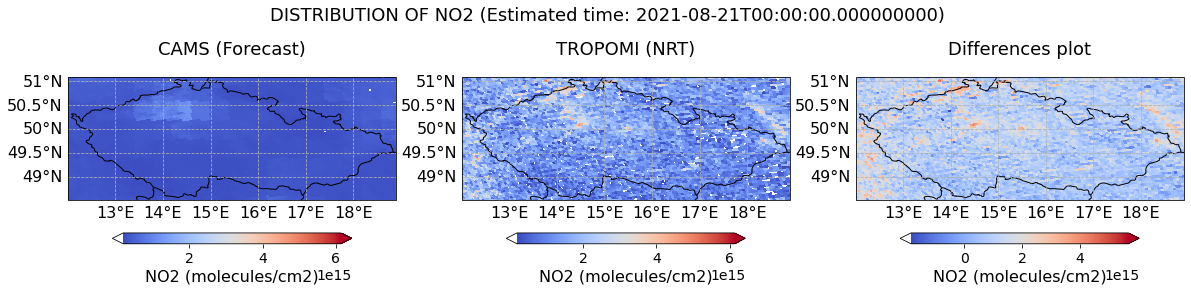

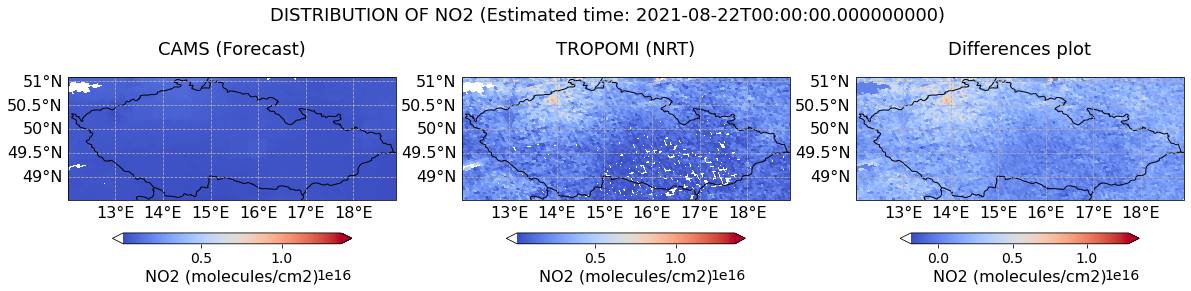

In [26]:
# Compare CAMS and TROPOMI total columns
range_type = 'Equal' # Original, Positive, Equal
visualize_model_vs_sensor(model, sensor, component_nom, merged_df, plot_dates, bbox, 20, 0.95, model_type, sensor_type, range_type)

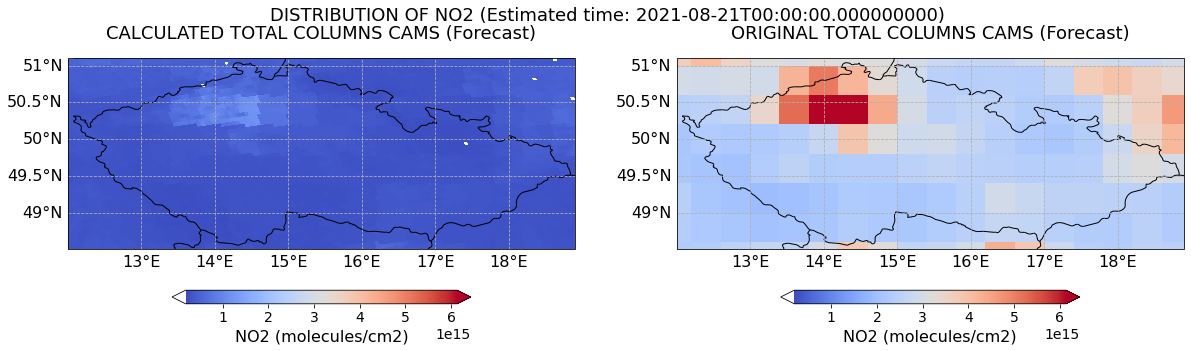

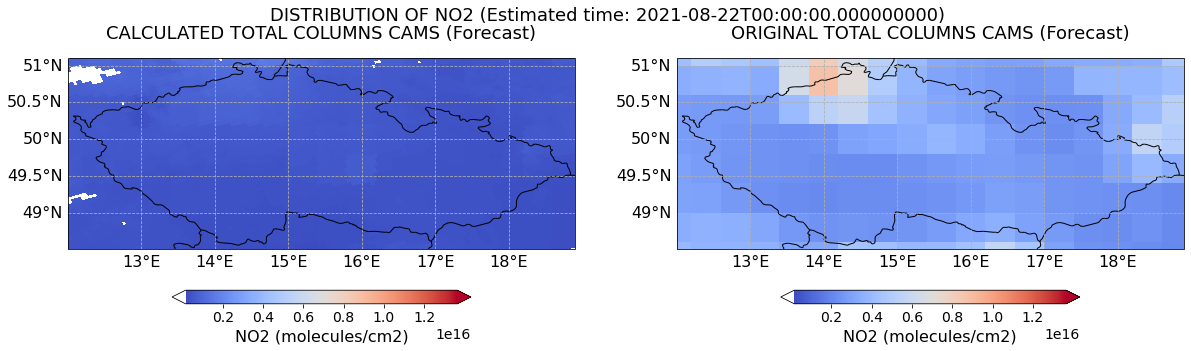

In [27]:
# Compare CAMS original and averaged total columns
range_type = 'Equal' # Original, Positive, Equal
visualize_model_original_vs_calculated(model, component_nom, merged_df, model_total_ds, plot_dates, bbox, 20, 0.95, model_type, range_type)

## 7. Scatter plots

Estimated time: 2021-08-21T00:00:00.000000000
Fit equation: Model NO2 = Sensor NO2 * 0.05 + (2.83E+14)
Coefficient of determination (R2): 0.08


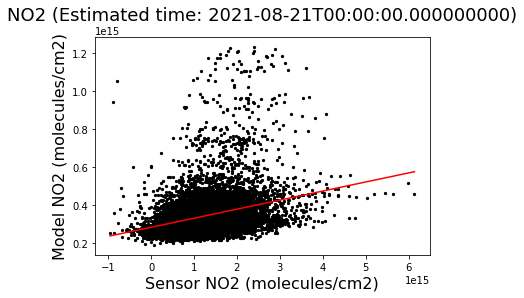

Estimated time: 2021-08-22T00:00:00.000000000
Fit equation: Model NO2 = Sensor NO2 * 0.11 + (2.60E+14)
Coefficient of determination (R2): 0.48


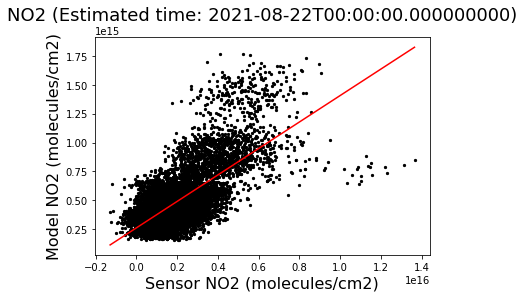

In [28]:
# Scatter plot and fit regression for CAMS vs. TROPOMI total columns
scatter_plot(merged_df.dropna(), component_nom, plot_dates, 1.05)